## **RNNs for Text Classification with PyTorch**

## Dataset Preparation

#### **Download  & explore movies dataset**

In [1]:
import pickle

with open("movies_dataset.pkl", "rb") as f:
    movies = pickle.load(f)

x, y = movies.data, movies.target
print(len(x), len(y))

2000 2000


# Inspect the data distribution

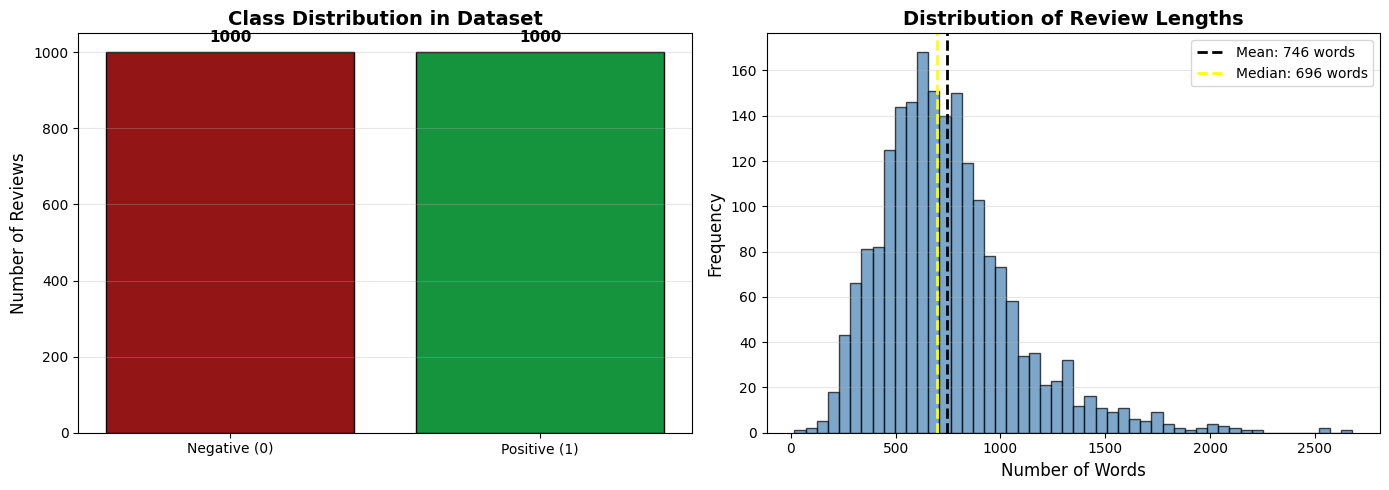

DATASET SUMMARY
Total reviews: 2000
Negative reviews: 1000 (50.0%)
Positive reviews: 1000 (50.0%)

Review Length Statistics:
  Min length: 17 words
  Max length: 2678 words
  Mean length: 746.3 words
  Median length: 696.5 words
  Std deviation: 328.3 words


In [2]:
from matplotlib import pyplot as plt
import numpy as np

# Plot 1: Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
class_counts = np.bincount(y)
axes[0].bar(['Negative (0)', 'Positive (1)'], class_counts, color=['#941515', '#15943d'], edgecolor='black')
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].set_title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
# Add count labels on bars
for i, count in enumerate(class_counts):
    axes[0].text(i, count + 20, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Review Length Distribution
review_lengths = [len(str(review).split()) for review in x]
axes[1].hist(review_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(review_lengths), color='black', linestyle='--', linewidth=2, label=f'Mean: {np.mean(review_lengths):.0f} words')
axes[1].axvline(np.median(review_lengths), color='yellow', linestyle='--', linewidth=2, label=f'Median: {np.median(review_lengths):.0f} words')
axes[1].set_xlabel('Number of Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Review Lengths', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total reviews: {len(x)}")
print(f"Negative reviews: {class_counts[0]} ({class_counts[0]/len(x)*100:.1f}%)")
print(f"Positive reviews: {class_counts[1]} ({class_counts[1]/len(x)*100:.1f}%)")
print(f"\nReview Length Statistics:")
print(f"  Min length: {min(review_lengths)} words")
print(f"  Max length: {max(review_lengths)} words")
print(f"  Mean length: {np.mean(review_lengths):.1f} words")
print(f"  Median length: {np.median(review_lengths):.1f} words")
print(f"  Std deviation: {np.std(review_lengths):.1f} words")
print("="*60)

In [3]:
import spacy
import re
from tqdm import tqdm

# Load spaCy model — for English, for Greek you may need something like "el_core_news_sm"
nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])  
# disabling parser and ner may speed up processing since you only need POS + lemma

docs = []
for doc_text in tqdm(x):
    # Remove non-word characters (punctuation etc)
    doc_clean = re.sub(r'\W', ' ', str(doc_text))
    # Remove single characters (optional)
    doc_clean = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc_clean)
    # Collapse multiple spaces
    doc_clean = re.sub(r'\s+', ' ', doc_clean, flags=re.I)
    # Lowercase
    doc_clean = doc_clean.lower().strip()
    
    # Process with spaCy
    doc = nlp(doc_clean)
    tokens = []
    for token in doc:
        # filter: only alphabetic tokens, non-stopwords, maybe length > 1
        if token.is_alpha and not token.is_stop:
            tokens.append(token.lemma_)
    # Reconstruct document string
    docs.append(" ".join(tokens))

print("\nOriginal review text:\n{}".format(x[0]))
print("\nFiltered review text:\n{}".format(docs[0]))
print("\nLabel:\n", y[0])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:20<00:00, 14.19it/s]


Original review text:
arnold schwarzenegger has been an icon for action enthusiasts , since the late 80's , but lately his films have been very sloppy and the one-liners are getting worse . 
it's hard seeing arnold as mr . freeze in batman and robin , especially when he says tons of ice jokes , but hey he got 15 million , what's it matter to him ? 
once again arnold has signed to do another expensive blockbuster , that can't compare with the likes of the terminator series , true lies and even eraser . 
in this so called dark thriller , the devil ( gabriel byrne ) has come upon earth , to impregnate a woman ( robin tunney ) which happens every 1000 years , and basically destroy the world , but apparently god has chosen one man , and that one man is jericho cane ( arnold himself ) . 
with the help of a trusty sidekick ( kevin pollack ) , they will stop at nothing to let the devil take over the world ! 
parts of this are actually so absurd , that they would fit right in with dogma . 
yes

In [4]:
from sklearn.model_selection import train_test_split

# 1️⃣ Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
        docs, y, test_size=0.3, random_state=2025)

# 2️⃣ Split temp into validation (10%) and test (20%)
# 10% of total = 10/30 = 1/3 of temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=(2/3), random_state=2025)

print(len(X_train), len(X_val), len(X_test))

1400 200 400


#### **Use spacy for sentence splitting & tokenization**

In [5]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner", "lemmatizer"])
nlp.add_pipe('sentencizer')

def tokenize_samples(samples):

  tokenized_samples = []
  for i in tqdm(range(len(samples))):
    doc = nlp(samples[i])  # Tokenize the sample into sentences
    tokens = []
    for sent in doc.sents:
      for tok in sent:  # Iterate through the words of the sentence
        # Filter out noise (newlines, special chars) and stop words
        if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
          continue
        if tok.text.strip(): # Check if token is not just whitespace
          tokens.append(tok.text.replace('"',"'").strip().lower()) # Normalize quotes and convert to lowercase
    tokenized_samples.append(tokens)

  return tokenized_samples

X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:11<00:00, 36.26it/s]


In [6]:
import numpy as np
# Get mean and std for length on training set
print('Average length of samples: {}'.format(np.mean([len(x) for x in X_train_tokenized])))
print('Std length of samples: {}'.format(np.std([len(x) for x in X_train_tokenized])))
print('#Samples with length > 1000: {} \n'.format(np.sum([len(x) > 1000 for x in X_train_tokenized])))
print('X_example: {}'.format(X_train_tokenized[0]))

Average length of samples: 304.35285714285715
Std length of samples: 132.74889208192886
#Samples with length > 1000: 1 

X_example: ['movie', 'like', 'day', 'seven', 'night', 'mad', 'talented', 'people', 'like', 'harrison', 'ford', 'anne', 'heche', 'ivan', 'reitman', 'lot', 'hard', 'work', 'script', 'worth', 'cent', 'script', 'write', 'michael', 'browning', 'decide', 'instead', 'think', 'new', 'idea', 'rehash', 'lot', 'cliche', 'omit', 'slight', 'bit', 'character', 'development', 'throw', 'drug', 'deal', 'pirate', 'provide', 'high', 'level', 'action', 'sequence', 'explosion', 'good', 'script', 'high', 'profile', 'actor', 'truman', 'instance', 'day', 'seven', 'night', 'simply', 'waste', 'let', 'harrison', 'ford', 'anne', 'heche', 'island', 'll', 'feisty', 'magazine', 'editor', 'll', 'crusty', 'old', 'pilot', 'wait', 'fianc', 'david', 'schwimmer', 'wait', 'fianc', 'harrison', 'ford', 'crash', 'island', 'know', 'll', 'vacation', 'spot', 'll', 'yessssss', 'll', 'crash', 'island', 'funny', 

### Build Vocabulary
- Create vocabulary of the MAX_WORDS most common words and set words as indexes corresponding to the vocabulary.
- Also, truncate or pad sequences to MAX_SEQUENCE_LENGTH

In [7]:
from collections import Counter

MAX_SEQUENCE_LENGTH = 300 # Truncate or pad sequences to this length
MAX_WORDS = 20000 # Size of vocabulary

# Build vocabulary from tokens in X_train_tokenized
all_tokens = [token for sentence in X_train_tokenized for token in sentence]
token_counts = Counter(all_tokens)

# Initialize vocabulary with special tokens <pad> (padding token) and <unk> (unknown token)
vocab = {"<pad>": 0, "<unk>": 1}

# Sort tokens by frequency in descending order and add to vocab starting from 2
for i, (token, _) in enumerate(token_counts.most_common(MAX_WORDS), start=2):
    vocab[token] = i

# Encode and pad each sentence
def encode_sentence(sentence, vocab, max_length=250):
    # Map each token to its vocabulary ID or <unk> if not in vocab
    encoded = [vocab.get(token, vocab["<unk>"]) for token in sentence]
    # Pad or truncate to max_length
    return encoded[:max_length] + [vocab["<pad>"]] * max(0, max_length - len(encoded))

# Apply encoding and padding to each sentence in X_train_tokenized
train_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_train_tokenized]
val_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_val_tokenized]
test_data = [encode_sentence(sentence, vocab, MAX_SEQUENCE_LENGTH) for sentence in X_test_tokenized]

In [8]:
len(vocab)

20002

In [9]:
# Reverse lookup check - Verify which words correspond to ID 0, 1, and 100
print(list(vocab.keys())[list(vocab.values()).index(0)])
print(list(vocab.keys())[list(vocab.values()).index(1)])
print(list(vocab.keys())[list(vocab.values()).index(100)])

<pad>
<unk>
laugh


In [10]:
# Example of a sentence encoding (the last 0's are the <pad> tokens)
print(train_data[123])

[1308, 1449, 1608, 21, 264, 923, 2, 1281, 644, 11465, 575, 2273, 2549, 4781, 470, 1763, 11150, 674, 17754, 1565, 6114, 247, 264, 1763, 6079, 11148, 1024, 3748, 1094, 510, 1105, 5062, 1738, 7267, 2432, 1893, 2309, 17755, 11466, 13788, 3444, 17756, 1493, 4349, 171, 1081, 130, 402, 11467, 1656, 2447, 1117, 549, 4034, 804, 624, 2170, 862, 11, 1813, 5133, 3172, 2505, 4781, 211, 13789, 9949, 205, 11467, 43, 1190, 1389, 17757, 32, 301, 596, 2481, 810, 9950, 34, 329, 47, 596, 1190, 7996, 13790, 17758, 15, 198, 97, 248, 8858, 17759, 2322, 11468, 235, 596, 717, 877, 17760, 1770, 2653, 2481, 6251, 3183, 587, 35, 9951, 190, 141, 301, 32, 301, 596, 1190, 5774, 7268, 400, 11467, 1795, 244, 6079, 220, 1190, 13, 2481, 5725, 371, 5091, 1565, 6114, 6252, 596, 13372, 60, 541, 7816, 17761, 183, 604, 183, 498, 766, 219, 14, 1281, 3, 335, 8, 2481, 496, 89, 911, 100, 1190, 809, 653, 5, 912, 611, 3, 4355, 725, 695, 475, 120, 335, 5832, 15, 15, 132, 13791, 1530, 587, 74, 11469, 34, 57, 17762, 15, 260, 17763, 9

### Word2Vec Embeddings

In [11]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')

In [12]:
# We have saved all the word2vec embeddings to a NumPy array for quick access
# Now, we save the word2vec embeddings for the words that we only need, based on the tokenizer
EMBEDDING_DIM = 300

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))  # +2 (pad, unkown)

# PAD is vector zero
# UNK is also vector zero
count = 0
for word, i in vocab.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_matrix[i] = word2vec[word]
        count+=1
    except:
        pass

#Return the number of the elements that are non-zero.
print(len(np.unique(np.nonzero(embedding_matrix)[0])))
print(count)

16430
16430


In [13]:
embedding_matrix.shape

(20002, 300)

#### Crucial: Memory Efficiency !!!

In [14]:
import gc # Garbage collector interface

# Free RAM
del word2vec
del vocab
gc.collect()  # ask Python to free RAM

43280

In [15]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import numpy as np

import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

`train_data`, `y_train`, `val_data`, `y_val`, `test_data`, `y_test` are lists of sentence encodings and labels

In [16]:
# Create datasets for train, validation, and test sets
train_dataset = TensorDataset(torch.tensor(train_data, dtype = torch.long), torch.tensor(y_train, dtype = torch.long))
val_dataset = TensorDataset(torch.tensor(val_data, dtype = torch.long), torch.tensor(y_val, dtype = torch.long))
test_dataset = TensorDataset(torch.tensor(test_data, dtype = torch.long), torch.tensor(y_test, dtype = torch.long))

# Create DataLoader for each dataset
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
import time
import os
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def train_with_early_stopping(
    model,  # The model to train
    train_loader, # DataLoader for training data
    val_loader, # DataLoader for validation data
    optimizer, # Optimizer for training the model
    criterion, # Loss function
    num_epochs=30,      # Maximum number of epochs to train
    patience=3,         # Number of epochs with no significant drop in the validation loss
    model_name="model", # Prefix for saving model checkpoints
    device="cuda",       # Device to run the training on
    min_delta=1e-4,     # Minimum change in the monitored quantity to qualify as an improvement
):
    """
    Train a model with early stopping on validation loss.
    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to be trained.
    train_loader : torch.utils.data.DataLoader
        DataLoader for training data.
    val_loader : torch.utils.data.DataLoader
        DataLoader for validation data.
    optimizer : torch.optim.Optimizer
        Optimizer for training the model.
    criterion : torch.nn.Module
        Loss function.
    num_epochs : int, optional
        Maximum number of epochs to train (default is 30).
    patience : int, optional
        Number of epochs with no significant drop in the validation loss before stopping (default is 3).
    model_name : str, optional
        Prefix for saving model checkpoints (default is "model").
    device : str or torch.device, optional
        Device to run the training on (default is "cpu").
    min_delta : float, optional
        Minimum change in the monitored quantity to qualify as an improvement (default is 1e-4).
    Returns
    -------
    history : dict
        Curves for plotting: train/val loss, accuracy, F1.
    best_model_path : str
        Path of the checkpoint with the best validation loss.
    """
    checkpoints_dir = Path.cwd().parent.resolve() / "checkpoints"
    checkpoints_dir.mkdir(parents=True, exist_ok=True)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_accuracy": [],
        "val_accuracy": [],
        "train_f1_score": [],
        "val_f1_score": [],
    }

    best_val_loss = float("inf")
    best_model_path = None
    epochs_without_improvement = 0

    start_training_time = time.time()
    # This is the optimization loop. Each time the optimizer sees all of the training data is called an "epoch".
    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train() # Set the model to training mode
        running_loss = 0.0
        train_outputs = []
        train_labels = []

        # This internal loop is where the optimizer sees all of the training data and where we
        # calculate the total_loss for all of the training data.
        for batch in train_loader: # or for features, labels in train_loader: | batch is a tuple (features, labels)
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Zero the gradients before running the backward pass, otherwise they accumulate from previous batches.
            # Forward pass
            outputs = model(features)

            # Calculate the loss with class indices (not one-hot)
            loss = criterion(outputs, labels) # Labels should be class indices, not one-hot
            loss.backward()  # Backward pass
            optimizer.step() # Optimize (update weights)

            running_loss += loss.item()
            # .detach() removes the computation graph so we don’t keep gradients around in memory; we only want the raw values for metrics.
            train_outputs.append(outputs.detach())
            train_labels.append(labels.detach())

        # Concatenate all outputs and labels for the epoch
        train_outputs = torch.cat(train_outputs)
        train_labels = torch.cat(train_labels)

        # Get label indices
        #train_classes = torch.argmax(train_labels, dim = 1)

        # Get predicted class indices
        train_pred = torch.argmax(train_outputs, dim=1)
        train_acc = accuracy_score(train_labels.cpu(), train_pred.cpu())
        train_f1 = f1_score(train_labels.cpu(), train_pred.cpu(), average="weighted")
        train_loss = running_loss / len(train_loader)

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_acc)
        history["train_f1_score"].append(train_f1)

        # ---------- Validation ----------
        model.eval() # Set the model to evaluation mode
        val_running_loss = 0.0
        all_outputs = []
        all_labels = []

        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                loss = criterion(outputs, labels) # Validation loss

                val_running_loss += loss.item()
                all_outputs.append(outputs)
                all_labels.append(labels)

        # Concatenate all outputs and labels for the epoch
        all_outputs = torch.cat(all_outputs)
        all_labels = torch.cat(all_labels)

        # Get label indices
        #true_classes = torch.argmax(all_labels, dim=1)

        # Get predicted class indices
        val_pred = torch.argmax(all_outputs, dim=1)

        # Calculate metrics on the entire validation set
        val_acc = accuracy_score(all_labels.cpu(), val_pred.cpu())
        val_f1 = f1_score(all_labels.cpu(), val_pred.cpu(), average="weighted")

        # Append to history
        val_loss = val_running_loss / len(val_loader)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)
        history["val_f1_score"].append(val_f1)

        # ---------- Logging ----------
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(
            f"  Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}\n"
            f"  Train acc:  {train_acc:.4f}  | Val acc:  {val_acc:.4f}\n"
            f"  Train F1:   {train_f1:.4f}  | Val F1:   {val_f1:.4f}"
        )

        # ---------- Early stopping + checkpointing ----------
        # Check if validation loss improved enough
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_without_improvement = 0

            new_model_path = checkpoints_dir / f"{model_name}_best_epoch_{epoch+1}.pth"
            # Delete the previous best model if it exists
            if best_model_path is not None and os.path.exists(best_model_path):
                os.remove(best_model_path)
            # Save the new best model
            torch.save(model.state_dict(), new_model_path)
            best_model_path = new_model_path # Update the best model path
            print(f"  ➜ New best model saved to {best_model_path}")
        else:
            epochs_without_improvement += 1
            print(
                f"  No improvement in val loss "
                f"({epochs_without_improvement}/{patience} epochs without improvement)."
            )
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

    total_time = time.time() - start_training_time
    print(f"Training finished in {total_time/60:.1f} minutes. "
          f"Best val loss: {best_val_loss:.4f}")

    return history, best_model_path

In [18]:
from sklearn.metrics import classification_report

def predict_with_loader(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    y_true = torch.cat(all_labels)
    y_pred = torch.cat(all_preds)
    return y_true, y_pred

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    # Plotting loss
    plt.figure()
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Over Epochs - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print() #print empty line
    # Plotting accuracy
    plt.figure()
    plt.plot(history['train_accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Over Epochs - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    print() #print empty line
    # Plotting F1 score
    plt.figure()
    plt.plot(history['train_f1_score'], label='Training F1 Score')
    plt.plot(history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'F1 Score Over Epochs - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

The following image is a recurrent neural network (RNN) shown in two views:

- **Left**: the compact view where the same cell feeds its hidden state back to itself.
- **Right**: the same cell unrolled through time.

---

**Green circles** (x, x_{t-1}, x_t, x_{t+1}) are the inputs at each time step (e.g. words in a sequence).

**Blue boxes** (h, h_{t-1}, h_t, h_{t+1}) are the hidden states of the RNN, which carry information from one time step to the next.

- The arrow labeled **V** is the recurrent connection: it passes the hidden state from time step t to time step t+1.

- The arrow labeled **U** is the connection from input to hidden state at each time step.

**Pink circles** (o, o_{t-1}, o_t, o_{t+1}) are the outputs (e.g. class scores, next-word logits) computed from the hidden states.

- The arrow labeled **W** is the connection from hidden state to output.

```The repeated U, V, W across time steps emphasize that the same parameters are shared at every time step in the sequence.```

---

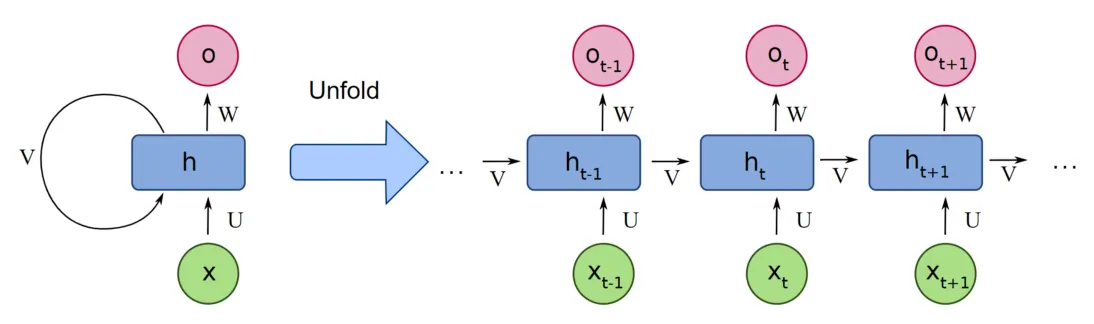

## Create and train a Stacked Bi-GRU RNN + MLP model (classification head / output layer).
- **It can take custom word embeddings or it can have custom end2end embeddings randomly initialized.**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BiGRU(nn.Module):
    def __init__(
        self,
        input_dim,
        n_classes,
        gru_hidden_dim=64,
        gru_stacks=1,
        dropout_prob=0.3,
        mlp_hidden_layers=[32],           # e.g. [] → no intermediate MLP, direct to logits
        matrix_embeddings=None,
        vocab_size=20000,
        embedding_dim=300,
        freeze_embeddings=True
    ):
        super().__init__()

        # --- Embedding layer ---
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size + 2,
            embedding_dim=embedding_dim,
            padding_idx=0
        )

        if matrix_embeddings is not None:
            self.embeddings.weight = nn.Parameter(matrix_embeddings, requires_grad=not freeze_embeddings)

        # --- Stacked BiGRU ---
        self.bigru = nn.GRU(
            input_size=input_dim,
            hidden_size=gru_hidden_dim,
            num_layers=gru_stacks,
            bidirectional=True,
            batch_first=True,
            dropout=(dropout_prob if gru_stacks > 1 else 0.0)
        )

        self.dropout = nn.Dropout(dropout_prob)

        # --- MLP classifier block ---
        mlp_layers = []
        prev_dim = gru_hidden_dim * 2

        for hidden_dim in mlp_hidden_layers:
            mlp_layers.append(nn.Linear(prev_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout_prob))
            prev_dim = hidden_dim

        # Final classifier layer
        mlp_layers.append(nn.Linear(prev_dim, n_classes))

        self.classifier = nn.Sequential(*mlp_layers)

    def forward(self, input):
        # Embeddings
        x = self.embeddings(input.long())

        # GRU forward
        gru_out, final_state = self.bigru(x)

        # final_state shape = (2 * gru_stacks, batch, hidden_dim)
        # get last layer’s forward + backward
        left_to_right_final = final_state[-2, :, :]
        right_to_left_final = final_state[-1, :, :]

        h = torch.cat([left_to_right_final, right_to_left_final], dim=1)

        # Classifier MLP
        return self.classifier(h)

### Train a model with Word2Vec embeddings

In [24]:
import torch
from torch.optim import Adam
from itertools import product
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"

# ======================
# Hyperparameter search space
# ======================
param_grid = {
    "gru_hidden_dim": [64, 128],
    "gru_stacks": [1, 2],
    "dropout_prob": [0.2, 0.4],
    "mlp_hidden_layers": [
        [32],
        [64, 32],
        [128, 64, 32]
    ],
    "lr": [1e-2, 5e-3]
}

# Generate all combinations
keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:
    
    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build a model with params
    # --------------------------
    model = BiGRU(
        input_dim=EMBEDDING_DIM,
        n_classes=len(movies.target_names),
        gru_hidden_dim=cfg["gru_hidden_dim"],
        gru_stacks=cfg["gru_stacks"],
        dropout_prob=cfg["dropout_prob"],
        mlp_hidden_layers=cfg["mlp_hidden_layers"],
        matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
        vocab_size=MAX_WORDS,
        embedding_dim=EMBEDDING_DIM,
        freeze_embeddings=True
    )

    model.to(device)

    optimizer = Adam(model.parameters(), lr=cfg["lr"])
    criterion = torch.nn.CrossEntropyLoss()

    # --------------------------
    # Train with early stopping
    # --------------------------
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name=f"grid_bigru_{hash(str(cfg))}",
        device=device,
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'gru_hidden_dim': 64, 'gru_stacks': 1, 'dropout_prob': 0.2, 'mlp_hidden_layers': [32], 'lr': 0.01}
Epoch 1/30
  Train loss: 0.6926 | Val loss: 0.6953
  Train acc:  0.5107  | Val acc:  0.5300
  Train F1:   0.5102  | Val F1:   0.5314
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_bigru_4932661527241391873_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6661 | Val loss: 0.7388
  Train acc:  0.5871  | Val acc:  0.5250
  Train F1:   0.5806  | Val F1:   0.5264
  No improvement in val loss (1/5 epochs without improvement).
Epoch 3/30
  Train loss: 0.6075 | Val loss: 0.7606
  Train acc:  0.6621  | Val acc:  0.5400
  Train F1:   0.6602  | Val F1:   0.5408
  No improvement in val loss (2/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.5396 | Val loss: 0.8454
  Train acc:  0.7214  | Val acc:  0.5550
  Train F1:   0.7209  | Val F1:   0.5559
  No improvement in val loss (3/5 epochs without improvement).
Epoch 5/30
  Train loss: 0.4514 | Val lo

In [25]:
model = BiGRU(
        input_dim=EMBEDDING_DIM,
        n_classes=len(movies.target_names),
        gru_hidden_dim=64,
        gru_stacks=2,
        dropout_prob=0.4,
        mlp_hidden_layers=[128, 64, 32],
        matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
        vocab_size=MAX_WORDS,
        embedding_dim=EMBEDDING_DIM,
        freeze_embeddings=True
    )

model.to(device)

optimizer = Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name=f"grid_bigru_{hash(str(cfg))}",
        device=device,
    )

Epoch 1/30
  Train loss: 0.6958 | Val loss: 0.6943
  Train acc:  0.4929  | Val acc:  0.4500
  Train F1:   0.4927  | Val F1:   0.3803
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_bigru_-4830347926148942900_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6901 | Val loss: 0.6945
  Train acc:  0.5336  | Val acc:  0.5150
  Train F1:   0.5020  | Val F1:   0.5157
  No improvement in val loss (1/5 epochs without improvement).
Epoch 3/30
  Train loss: 0.6891 | Val loss: 0.6971
  Train acc:  0.5450  | Val acc:  0.5200
  Train F1:   0.5432  | Val F1:   0.5209
  No improvement in val loss (2/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.6725 | Val loss: 0.6767
  Train acc:  0.5821  | Val acc:  0.5800
  Train F1:   0.5819  | Val F1:   0.5398
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_bigru_-4830347926148942900_best_epoch_4.pth
Epoch 5/30
  Train loss: 0.6321 | Val loss: 0.7664
  Train acc:  0.6479  | Val acc:  0.5500
  Train F1:   0.

In [26]:
# Free any unused GPU memory first (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load checkpoint explicitly to CPU, then load into model
state_dict = torch.load(best_model_path, map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
del state_dict
gc.collect()  # ask Python to free RAM

# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 58.00%
              precision    recall  f1-score   support

         neg       0.58      0.84      0.69       111
         pos       0.56      0.26      0.35        89

    accuracy                           0.58       200
   macro avg       0.57      0.55      0.52       200
weighted avg       0.57      0.58      0.54       200



Test Accuracy: 58.00%


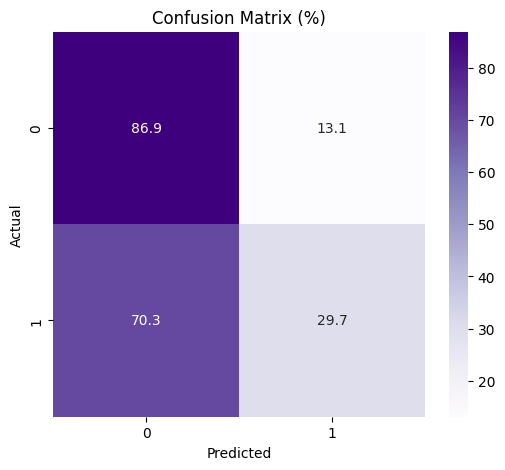

In [29]:
from sklearn.metrics import confusion_matrix

# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.59993499349935


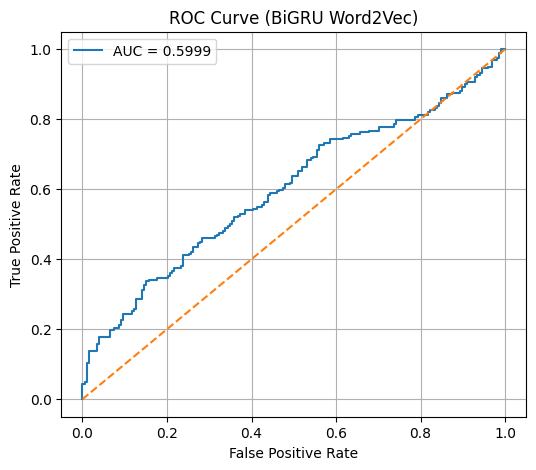

In [26]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BiGRU Word2Vec)")
plt.legend()
plt.grid(True)
plt.show()

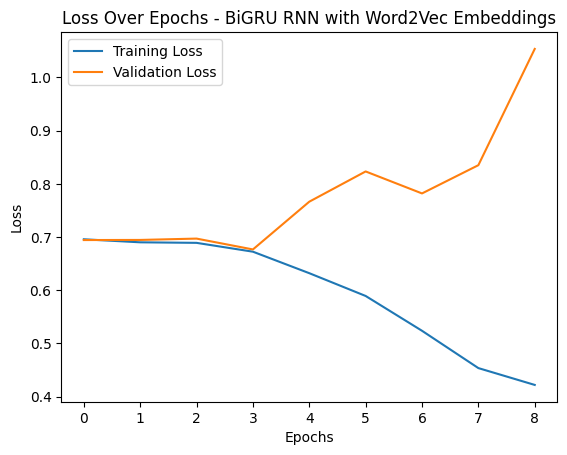

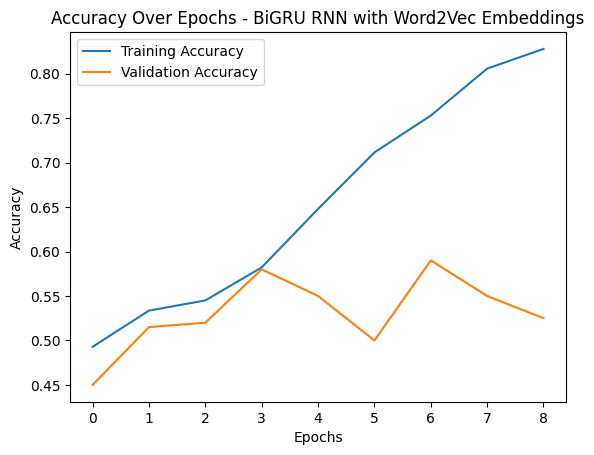

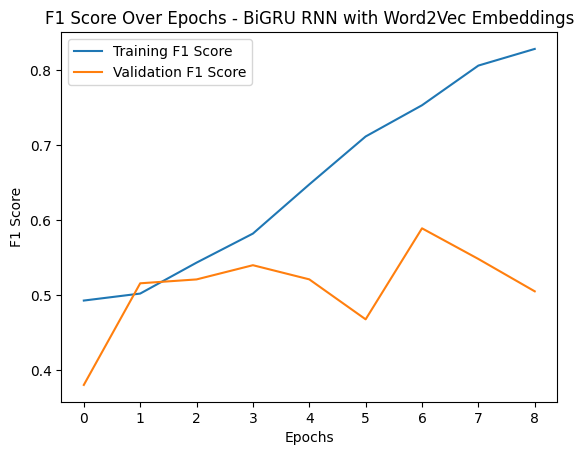

In [30]:
plot_training_history(history, "BiGRU RNN with Word2Vec Embeddings")

## Train a Stacked Bi-GRU RNN with custom embeddings

In [31]:
# ======================
# Hyperparameter search space
# ======================
param_grid = {
    "gru_hidden_dim": [64, 128],
    "gru_stacks": [1, 2],
    "dropout_prob": [0.2, 0.4],
    "mlp_hidden_layers": [
        [32],
        [64, 32],
        [128, 64, 32]
    ],
    "lr": [1e-2, 5e-3]
}

# Generate all combinations
keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:
    
    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build a model with params
    # --------------------------
    model = BiGRU(
        input_dim=EMBEDDING_DIM,
        n_classes=len(movies.target_names),
        gru_hidden_dim=cfg["gru_hidden_dim"],
        gru_stacks=cfg["gru_stacks"],
        dropout_prob=cfg["dropout_prob"],
        mlp_hidden_layers=cfg["mlp_hidden_layers"],
        matrix_embeddings=None
    )

    model.to(device)

    optimizer = Adam(model.parameters(), lr=cfg["lr"])
    criterion = torch.nn.CrossEntropyLoss()

    # --------------------------
    # Train with early stopping
    # --------------------------
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name=f"grid_bigru_{hash(str(cfg))}",
        device=device,
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'gru_hidden_dim': 64, 'gru_stacks': 1, 'dropout_prob': 0.2, 'mlp_hidden_layers': [32], 'lr': 0.01}
Epoch 1/30
  Train loss: 0.6949 | Val loss: 0.7052
  Train acc:  0.5243  | Val acc:  0.5150
  Train F1:   0.5151  | Val F1:   0.5005
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\grid_bigru_4932661527241391873_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.5055 | Val loss: 0.8306
  Train acc:  0.7857  | Val acc:  0.5700
  Train F1:   0.7835  | Val F1:   0.5689
  No improvement in val loss (1/5 epochs without improvement).
Epoch 3/30
  Train loss: 0.2148 | Val loss: 1.3809
  Train acc:  0.9179  | Val acc:  0.5750
  Train F1:   0.9179  | Val F1:   0.5735
  No improvement in val loss (2/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.0388 | Val loss: 2.1158
  Train acc:  0.9850  | Val acc:  0.5850
  Train F1:   0.9850  | Val F1:   0.5801
  No improvement in val loss (3/5 epochs without improvement).
Epoch 5/30
  Train loss: 0.0190 | Val lo

In [33]:
torch.manual_seed(1)

model = BiGRU(
    input_dim=EMBEDDING_DIM,
    n_classes=len(movies.target_names),
    matrix_embeddings=None,
    gru_hidden_dim=64,
    gru_stacks=2,
    dropout_prob = 0.4,
    mlp_hidden_layers = [64, 32]
).to(device)

optimizer = Adam(model.parameters(), lr = 0.01)
                                                
criterion = nn.CrossEntropyLoss()

history, best_model_path = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=30,
    patience=5,
    model_name="bigru_custom",
    device=device,
)

Epoch 1/30
  Train loss: 0.6958 | Val loss: 0.6933
  Train acc:  0.5064  | Val acc:  0.5200
  Train F1:   0.5016  | Val F1:   0.5171
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bigru_custom_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.5924 | Val loss: 0.8172
  Train acc:  0.6950  | Val acc:  0.5900
  Train F1:   0.6950  | Val F1:   0.5593
  No improvement in val loss (1/5 epochs without improvement).
Epoch 3/30
  Train loss: 0.3863 | Val loss: 1.0968
  Train acc:  0.8686  | Val acc:  0.5700
  Train F1:   0.8684  | Val F1:   0.5682
  No improvement in val loss (2/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.1955 | Val loss: 1.3848
  Train acc:  0.9393  | Val acc:  0.5850
  Train F1:   0.9393  | Val F1:   0.5852
  No improvement in val loss (3/5 epochs without improvement).
Epoch 5/30
  Train loss: 0.0511 | Val loss: 2.3762
  Train acc:  0.9900  | Val acc:  0.6000
  Train F1:   0.9900  | Val F1:   0.6011
  No improvement in val loss (4/5 epochs without

In [35]:
from sklearn.metrics import classification_report

# Free any unused GPU memory first (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load checkpoint explicitly to CPU, then load into model
state_dict = torch.load(best_model_path, map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
del state_dict
gc.collect()  # ask Python to free RAM

# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 52.00%
              precision    recall  f1-score   support

         neg       0.56      0.60      0.58       111
         pos       0.46      0.42      0.44        89

    accuracy                           0.52       200
   macro avg       0.51      0.51      0.51       200
weighted avg       0.52      0.52      0.52       200



Test Accuracy: 56.00%


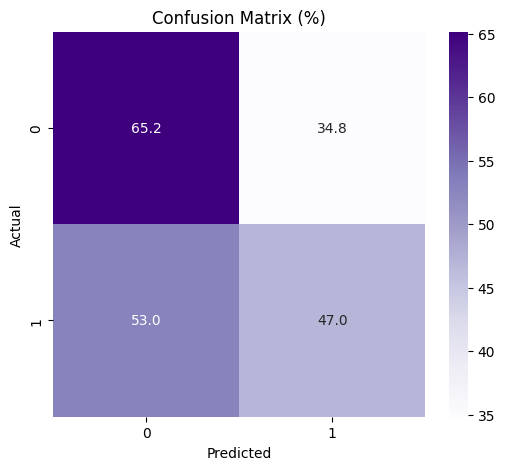

In [36]:
# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.5699569956995699


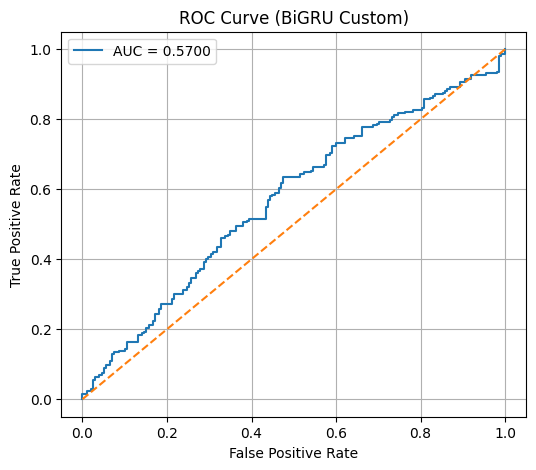

In [32]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BiGRU Custom)")
plt.legend()
plt.grid(True)
plt.show()

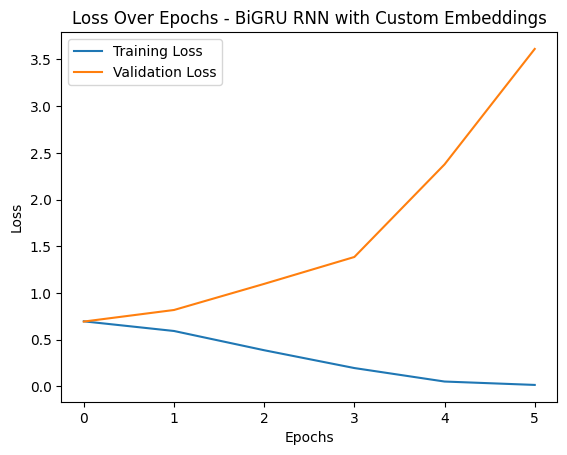

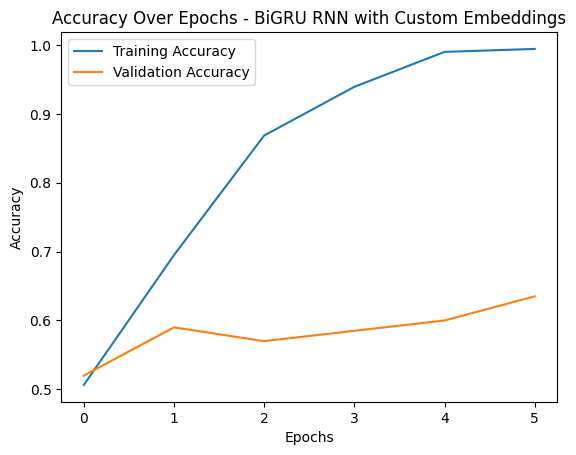

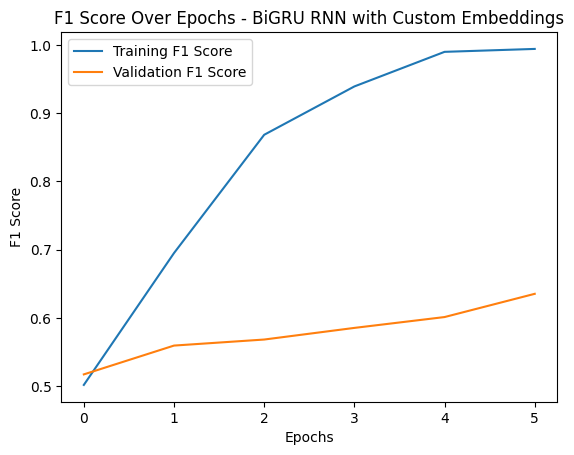

In [37]:
plot_training_history(history, "BiGRU RNN with Custom Embeddings")

`train_data`, `y_train`, `val_data`, `y_val`, `test_data`, `y_test` are lists of sentence encodings and labels


In [38]:
# Create datasets for train, validation, and test sets
train_dataset = TensorDataset(torch.tensor(train_data, dtype = torch.long), torch.tensor(y_train, dtype = torch.long))
val_dataset = TensorDataset(torch.tensor(val_data, dtype = torch.long), torch.tensor(y_val, dtype = torch.long))
test_dataset = TensorDataset(torch.tensor(test_data, dtype = torch.long), torch.tensor(y_test, dtype = torch.long))

BATCH_SIZE = 128
# Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## BiLSTM with "Deep" Self-Attention

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

LSTM_SIZE = 128 # Number of units in the LSTM layer
LSTM_STACKS = 1 # Number of LSTM stacks
DENSE = 256 # Number of units in the dense layer
MAX_WORDS = 20000 # Size of vocabulary
EMBEDDING_DIM = 300 # Embedding dimensions
ATTENTION_DIM = 256 # Number of units in the attention MLP hidden layer

class BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dim, lstm_hidden_dim, lstm_stacks, attention_hidden_dim, matrix_embeddings=None):
        super(BiLSTM_Attention, self).__init__()

        # dimensions
        self.input_dim = input_dim
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_stacks = lstm_stacks
        self.attention_hidden_dim = attention_hidden_dim

        # Embedding layer
        if matrix_embeddings is not None:
            self.embeddings = nn.Embedding(num_embeddings=MAX_WORDS + 2, embedding_dim=EMBEDDING_DIM, padding_idx=0).from_pretrained(matrix_embeddings)
            self.embeddings.requires_grad = False  # Don't change the embedding matrix
        else:
            self.embeddings = nn.Embedding(num_embeddings=MAX_WORDS + 2, embedding_dim=EMBEDDING_DIM, padding_idx=0)
            self.embeddings.requires_grad = True  # Learn the embedding matrix

        # LSTM layer (replacing GRU)
        self.bilstm = nn.LSTM(input_size=self.input_dim,
                              hidden_size=self.lstm_hidden_dim,
                              num_layers=self.lstm_stacks,
                              bidirectional=True,
                              batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.33)

        # Attention MLP
        self.deep_attention_mlp = nn.Sequential(
            nn.Linear(2 * self.lstm_hidden_dim, self.attention_hidden_dim),
            nn.Tanh(),
            #nn.Dropout(0.33),
            nn.Linear(self.attention_hidden_dim, 1)
        )

        # Dense layer
        self.dense1 = nn.Linear(self.lstm_hidden_dim * 2, self.hidden_dim)  # lstm_hidden_dim*2 because bidirectional

        # Classification layer
        self.dense2 = nn.Linear(self.hidden_dim, self.n_classes)

    def forward(self, input):
        # Input shape: (batch_size, sequence_length)

        # Embedding layer
        x = self.embeddings(input.long())  # (batch_size, sequence_length, embedding_dim)

        # Dropout embeddings
        x = self.dropout(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.bilstm(x)  # lstm_out (batch_size, sequence_length, 2*lstm_hidden_dim)
                                               # h_n and c_n (2, batch_size, lstm_hidden_dim)

        # Attention MLP
        attention_scores = self.deep_attention_mlp(lstm_out)  # (batch_size, sequence_length, 1)

        # Softmax to get the attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, sequence_length, 1)

        # Weigh the history with the attention weights
        attended_output = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, 2*lstm_hidden_dim)

        # Dropout after the attended output
        x = self.dropout(attended_output) # (batch_size, 2*lstm_hidden_dim)

        # Dense layer 1
        x = F.relu(self.dense1(x))  # (batch_size, hidden_dim)

        # Dropout
        x = self.dropout(x)  # (batch_size, hidden_dim)

        # Output layer
        logits = self.dense2(x)  # (batch_size, n_classes)

        return logits


# Instantiate the model with LSTM
bilstm_attn = BiLSTM_Attention(input_dim=EMBEDDING_DIM,
              n_classes=len(movies.target_names),
              matrix_embeddings=torch.tensor(embedding_matrix, dtype=torch.float32),
              hidden_dim=DENSE,
              lstm_hidden_dim=LSTM_SIZE,
              attention_hidden_dim=ATTENTION_DIM,
              lstm_stacks=1)

print(bilstm_attn)

print(f"Total learnable parameters: {sum(p.numel() for p in bilstm_attn.parameters() if p.requires_grad)}")


BiLSTM_Attention(
  (embeddings): Embedding(20002, 300)
  (bilstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.33, inplace=False)
  (deep_attention_mlp): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=2, bias=True)
)
Total learnable parameters: 572675


## Train a stacked Bi-LSTM RNN with Word2Vec embeddings and "Deep" self-attention
- The extra MLP on top (and the multi-layer attention MLP in BiLSTM_Attention) makes the network “deep”

In [40]:
# ======================
# Hyperparameter search space
# ======================
param_grid = {
    "dense": [128, 256],
    "lstmStacks": [1, 2],
    "lstmSize": [128, 256],
    "attDim": [256, 512],
    "lr": [1e-2, 5e-3]
}

LSTM_SIZE = 128 # Number of units in the LSTM layer
LSTM_STACKS = 1 # Number of LSTM stacks
DENSE = 256 # Number of units in the dense layer
MAX_WORDS = 20000 # Size of vocabulary
EMBEDDING_DIM = 300 # Embedding dimensions
ATTENTION_DIM = 256 # Number of units in the attention MLP hidden layer

# Generate all combinations
keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:
    
    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build a model with params
    # --------------------------
    torch.manual_seed(1)
    
    # Initialize the model
    model = BiLSTM_Attention(input_dim=EMBEDDING_DIM,
                  n_classes=len(movies.target_names),
                  matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float32),
                  hidden_dim=cfg['dense'],
                  lstm_hidden_dim=cfg['lstmSize'],
                  attention_hidden_dim = cfg['attDim'],
                  lstm_stacks = cfg['lstmStacks'])
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr = cfg['lr'])
    
    criterion = nn.CrossEntropyLoss()
    
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name="bilstm_attention_word2vec",
        device=device,
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'dense': 128, 'lstmStacks': 1, 'lstmSize': 128, 'attDim': 256, 'lr': 0.01}
Epoch 1/30
  Train loss: 0.6930 | Val loss: 0.6724
  Train acc:  0.5357  | Val acc:  0.6850
  Train F1:   0.5348  | Val F1:   0.6834
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_word2vec_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6545 | Val loss: 0.6331
  Train acc:  0.6214  | Val acc:  0.6050
  Train F1:   0.6207  | Val F1:   0.4992
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_word2vec_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.6316 | Val loss: 0.5778
  Train acc:  0.6757  | Val acc:  0.6900
  Train F1:   0.6733  | Val F1:   0.6802
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_word2vec_best_epoch_3.pth
Epoch 4/30
  Train loss: 0.5528 | Val loss: 0.5787
  Train acc:  0.7364  | Val acc:  0.7250
  Train F1:   0.7360  | Val F1:   0.6976
  No improvement in val loss (1/5 ep

In [41]:
torch.manual_seed(1)

# Initialize the model
model = BiLSTM_Attention(input_dim=EMBEDDING_DIM,
              n_classes=len(movies.target_names),
              matrix_embeddings=torch.tensor(embedding_matrix, dtype = torch.float32),
              hidden_dim=256,
              lstm_hidden_dim=128,
              attention_hidden_dim = 512,
              lstm_stacks = 2)
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.005)

criterion = nn.CrossEntropyLoss()

history, best_model_path = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=30,
    patience=5,
    model_name="bilstm_attention_word2vec",
    device=device,
)

Epoch 1/30
  Train loss: 0.6962 | Val loss: 0.6633
  Train acc:  0.5036  | Val acc:  0.5550
  Train F1:   0.4635  | Val F1:   0.3962
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_word2vec_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6569 | Val loss: 0.6081
  Train acc:  0.6007  | Val acc:  0.7100
  Train F1:   0.5935  | Val F1:   0.7107
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_word2vec_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.6340 | Val loss: 0.6117
  Train acc:  0.6329  | Val acc:  0.6250
  Train F1:   0.6286  | Val F1:   0.5358
  No improvement in val loss (1/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.5642 | Val loss: 0.7121
  Train acc:  0.7150  | Val acc:  0.6250
  Train F1:   0.7139  | Val F1:   0.5928
  No improvement in val loss (2/5 epochs without improvement).
Epoch 5/30
  Train loss: 0.4735 | Val loss: 0.4479
  Train acc:  0.7886  | Val acc:  0.8200
  Train F1:   0.7883  | Val 

In [42]:
from sklearn.metrics import classification_report

# Free any unused GPU memory first (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load checkpoint explicitly to CPU, then load into model
state_dict = torch.load(best_model_path, map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
del state_dict
gc.collect()  # ask Python to free RAM

# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 87.50%
              precision    recall  f1-score   support

         neg       0.85      0.95      0.89       111
         pos       0.92      0.79      0.85        89

    accuracy                           0.88       200
   macro avg       0.88      0.87      0.87       200
weighted avg       0.88      0.88      0.87       200



Test Accuracy: 84.75%


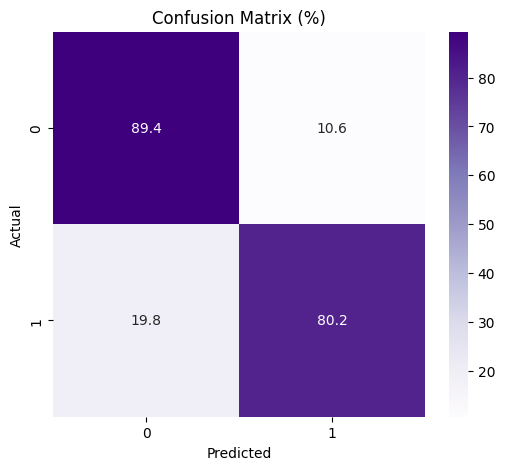

In [43]:
# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.9324432443244325


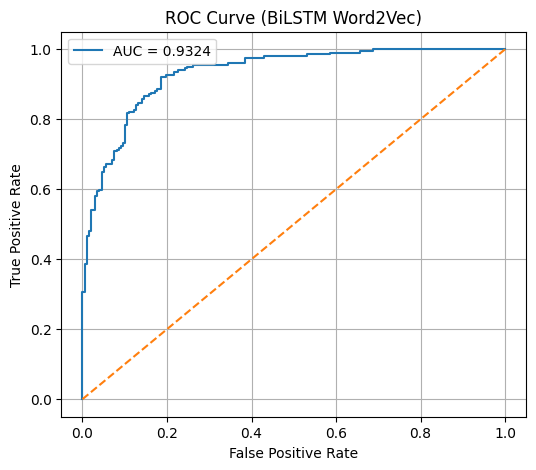

In [40]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BiLSTM Word2Vec)")
plt.legend()
plt.grid(True)
plt.show()

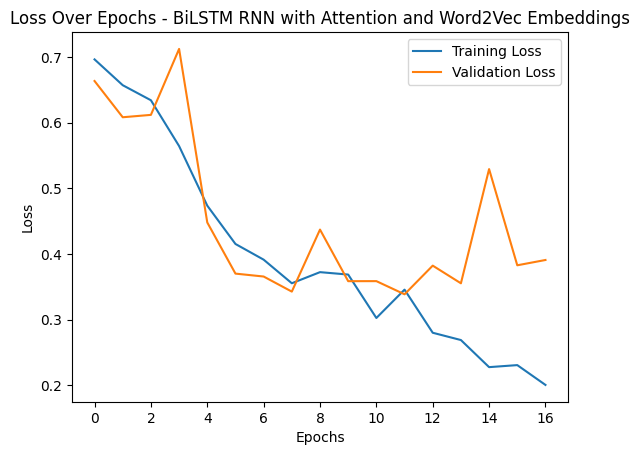

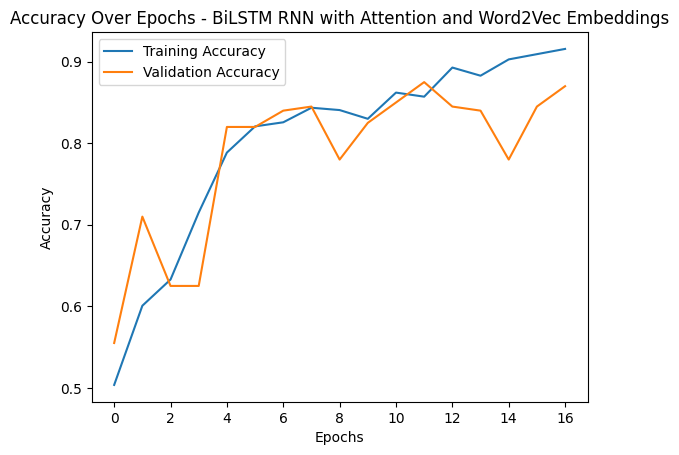

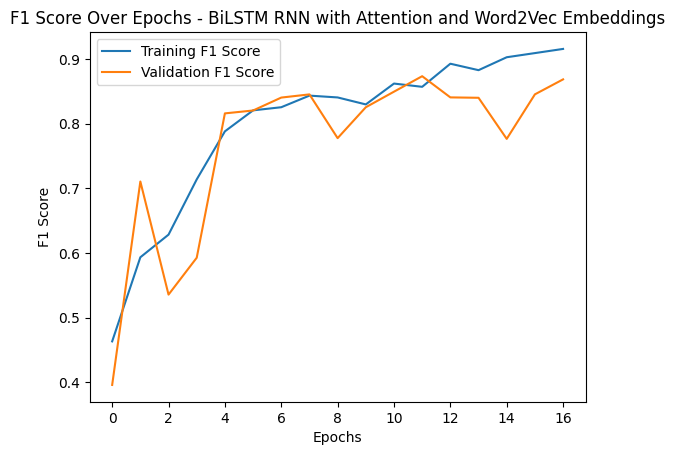

In [44]:
plot_training_history(history, "BiLSTM RNN with Attention and Word2Vec Embeddings")

## Train a stacked Bi-LSTM RNN with custom embeddings and "Deep" self-attention

In [45]:
# ======================
# Hyperparameter search space
# ======================
param_grid = {
    "dense": [128, 256],
    "lstmStacks": [1, 2],
    "lstmSize": [128, 256],
    "attDim": [256, 512],
    "lr": [1e-2, 5e-3]
}

LSTM_SIZE = 128 # Number of units in the LSTM layer
LSTM_STACKS = 1 # Number of LSTM stacks
DENSE = 256 # Number of units in the dense layer
MAX_WORDS = 20000 # Size of vocabulary
EMBEDDING_DIM = 300 # Embedding dimensions
ATTENTION_DIM = 256 # Number of units in the attention MLP hidden layer

# Generate all combinations
keys = list(param_grid.keys())
configs = list(product(*param_grid.values()))

best_acc = -1
best_config = None
results = []

for cfg_values in configs:
    
    cfg = dict(zip(keys, cfg_values))
    print("\n==========================================")
    print("Training with config:", cfg)
    print("==========================================")

    # --------------------------
    # Build a model with params
    # --------------------------
    torch.manual_seed(1)
    
    # Initialize the model
    model = BiLSTM_Attention(input_dim=EMBEDDING_DIM,
                  n_classes=len(movies.target_names),
                  hidden_dim=cfg['dense'],
                  lstm_hidden_dim=cfg['lstmSize'],
                  attention_hidden_dim = cfg['attDim'],
                  lstm_stacks = cfg['lstmStacks'])
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr = cfg['lr'])
    
    criterion = nn.CrossEntropyLoss()
    
    history, best_model_path = train_with_early_stopping(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        num_epochs=30,
        patience=5,
        model_name="bilstm_attention_custom",
        device=device,
    )

    val_acc = max(history["val_accuracy"])
    results.append((cfg, val_acc))

    print(f"VAL ACC: {val_acc:.4f}")

    # Track best
    if val_acc > best_acc:
        best_acc = val_acc
        best_config = cfg


print("\n==========================================")
print("BEST CONFIG:")
print(best_config)
print(f"BEST VAL ACC: {best_acc:.4f}")
print("==========================================")


Training with config: {'dense': 128, 'lstmStacks': 1, 'lstmSize': 128, 'attDim': 256, 'lr': 0.01}
Epoch 1/30
  Train loss: 0.6742 | Val loss: 0.6030
  Train acc:  0.5993  | Val acc:  0.6550
  Train F1:   0.5993  | Val F1:   0.6543
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_custom_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.5201 | Val loss: 0.5239
  Train acc:  0.7471  | Val acc:  0.7550
  Train F1:   0.7467  | Val F1:   0.7483
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_custom_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.2680 | Val loss: 0.6410
  Train acc:  0.9157  | Val acc:  0.7500
  Train F1:   0.9157  | Val F1:   0.7427
  No improvement in val loss (1/5 epochs without improvement).
Epoch 4/30
  Train loss: 0.0761 | Val loss: 0.7904
  Train acc:  0.9750  | Val acc:  0.7600
  Train F1:   0.9750  | Val F1:   0.7590
  No improvement in val loss (2/5 epochs without improvement).
Epoch 5/30
  Train loss: 

In [46]:
torch.manual_seed(1)

# Initialize the model
model = BiLSTM_Attention(input_dim=EMBEDDING_DIM,
              n_classes=len(movies.target_names),
              hidden_dim=256,
              lstm_hidden_dim=256,
              attention_hidden_dim = 256,
              lstm_stacks = 1)
model.to(device)

optimizer = Adam(model.parameters(), lr = 0.01)

criterion = nn.CrossEntropyLoss()

history, best_model_path = train_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=30,
    patience=5,
    model_name="bilstm_attention_custom",
    device=device,
)

Epoch 1/30
  Train loss: 0.7318 | Val loss: 0.6684
  Train acc:  0.5200  | Val acc:  0.6600
  Train F1:   0.5099  | Val F1:   0.6596
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_custom_best_epoch_1.pth
Epoch 2/30
  Train loss: 0.6152 | Val loss: 0.5479
  Train acc:  0.6921  | Val acc:  0.7050
  Train F1:   0.6921  | Val F1:   0.6933
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_custom_best_epoch_2.pth
Epoch 3/30
  Train loss: 0.4771 | Val loss: 0.4601
  Train acc:  0.8193  | Val acc:  0.8350
  Train F1:   0.8193  | Val F1:   0.8326
  ➜ New best model saved to C:\FORMAT LAP HP\jim\CS\NLP\checkpoints\bilstm_attention_custom_best_epoch_3.pth
Epoch 4/30
  Train loss: 0.1716 | Val loss: 0.6713
  Train acc:  0.9493  | Val acc:  0.7900
  Train F1:   0.9493  | Val F1:   0.7905
  No improvement in val loss (1/5 epochs without improvement).
Epoch 5/30
  Train loss: 0.0662 | Val loss: 0.9189
  Train acc:  0.9757  | Val

In [47]:
from sklearn.metrics import classification_report

# Free any unused GPU memory first (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Load checkpoint explicitly to CPU, then load into model
state_dict = torch.load(best_model_path, map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
del state_dict
gc.collect()  # ask Python to free RAM

# Set the model to evaluation mode
model.eval()

# Validation
y_true_val, y_pred_val = predict_with_loader(model, val_loader, device)
print("Validation Accuracy: {:.2f}%".format(
    accuracy_score(y_true_val, y_pred_val) * 100
))
print(classification_report(
    y_true_val, y_pred_val, target_names=movies.target_names
))

Validation Accuracy: 83.50%
              precision    recall  f1-score   support

         neg       0.81      0.92      0.86       111
         pos       0.88      0.73      0.80        89

    accuracy                           0.83       200
   macro avg       0.84      0.82      0.83       200
weighted avg       0.84      0.83      0.83       200



Test Accuracy: 80.50%


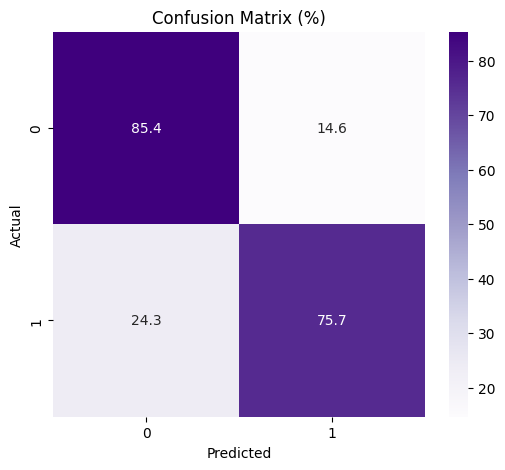

In [48]:
# Test
y_true_test, y_pred_test = predict_with_loader(model, test_loader, device)
print("Test Accuracy: {:.2f}%".format(
    accuracy_score(y_true_test, y_pred_test) * 100
))

# Compute confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Compute percentages
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Plot with percentages
plt.figure(figsize=(6,5))
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Purples', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (%)')
plt.show()

# Free RAM
del y_true_val, y_pred_val, y_true_test, y_pred_test
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

AUC score: 0.8896139613961396


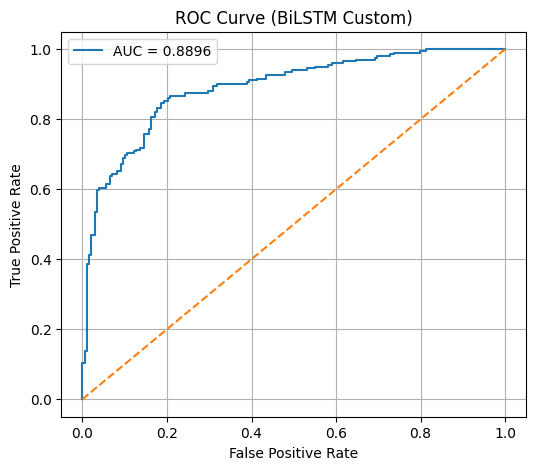

In [46]:
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Put model in eval mode
model.eval()

# Collect probabilities and labels
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:   # use your test loader
        features = features.to('cuda')
        labels = labels.to('cuda')
        logits = model(features)      # raw model output
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1

        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Convert to flat numpy arrays
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Compute AUC
auc_score = auc(fpr, tpr)
print("AUC score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (BiLSTM Custom)")
plt.legend()
plt.grid(True)
plt.show()

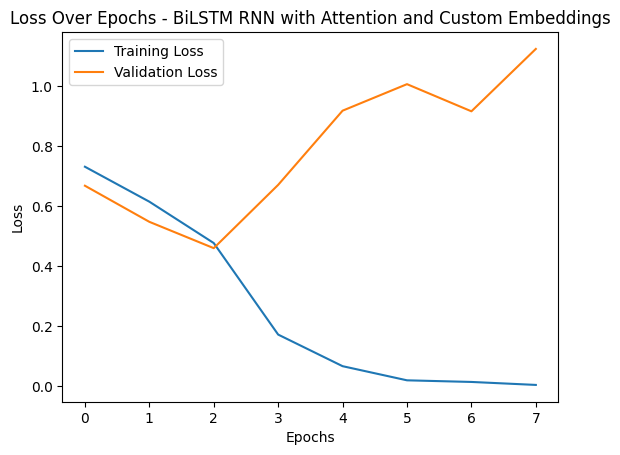

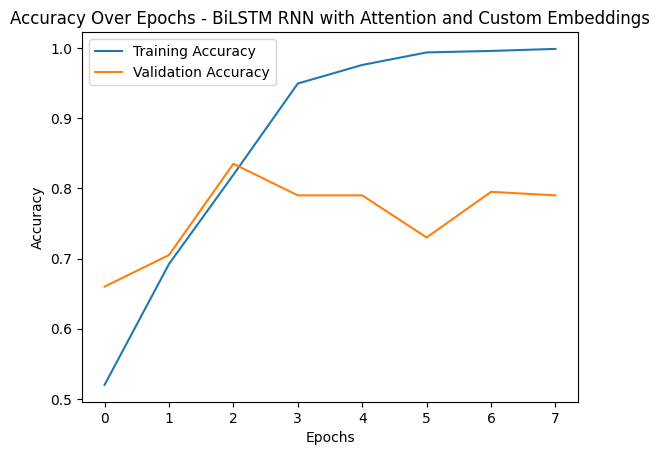

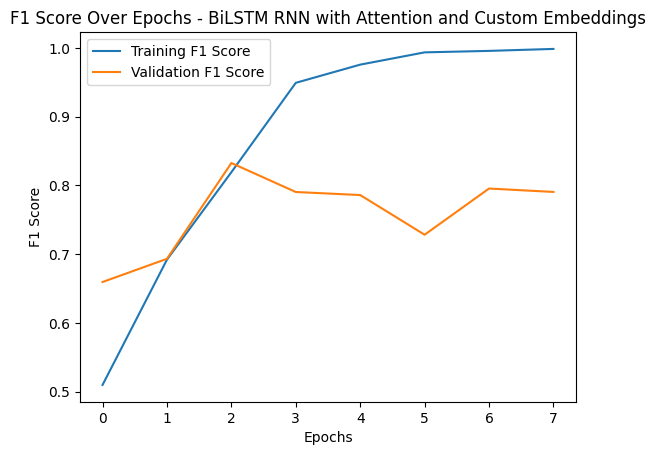

In [49]:
plot_training_history(history, "BiLSTM RNN with Attention and Custom Embeddings")

# Final Results in movies

|                   Model Name                      |Epochs Trained|Val Accuracy %|Test Accuracy %|
|---------------------------------------------------|--------------|--------------|---------------|
|Bi-GRU RNN with Word2Vec                           |      9       |58.00         |58.00          |
|Bi-GRU RNN with custom embeddings                  |      6       |52.00         |56.00          |
|**Bi-LSTM RNN with Word2Vec & self-attention**     |      17      |**87.50**     |**84.75**      |
|Bi-LSTM RNN with custom embeddings & self-attention|      8       |83.50         |80.50          |
